In [147]:
import os
import sys

try:
    # This will work when run as a script
    sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
except NameError:
    # This will work when run in an interactive environment
    sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'utils','..')))


from utils.read import TimeSeriesDataset

lookback = 2  # Number of time steps to look back
features = ['Open', 'High', 'Low', 'Volume']  # Features to include in x
target_feature = 'Close'  # Target feature for y
filename = "sbb.us.txt"  # File to load data from
dataset_creator = TimeSeriesDataset(lookback, features, target_feature)
x, y, df = dataset_creator.create_dataset(filename)

if x is not None and y is not None:
    print("Original Shape of x:", x.shape)
    print("Original Shape of y:", y.shape)
    print("First 1 x samples:")
    print(x[0])
    print("First 1 y samples:")
    print(y[0])
    # Fit scalers
    dataset_creator.fit_scalers(df)
    # Transform data
    x_transformed, y_transformed = dataset_creator.transform(x, y)
    print("\nTransformed Shape of x:", x_transformed.shape)
    print("Transformed Shape of y:", y_transformed.shape)
    print("First 1 transformed x samples:")
    print(x_transformed[0])
    print("First 1 transformed y samples:")
    print(y_transformed[0])
    # Inverse transform data
    x_original, y_original = dataset_creator.inverse_transform(x_transformed, y_transformed)
    print("\nInverse Transformed Shape of x:", x_original.shape)
    print("Inverse Transformed Shape of y:", y_original.shape)
    print("First 1 inverse transformed x samples:")
    print(x_original[0])
    print("First 1 inverse transformed y samples:")
    print(y_original[0])
else:
    print(f"Failed to create dataset for {filename}")
    
split_index = int(len(x_transformed) * 0.90)
X_train = x_transformed[:split_index]
X_test = x_transformed[split_index:]

y_train = y_transformed[:split_index]
y_test = y_transformed[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape


Original Shape of x: (2542, 2, 4)
Original Shape of y: (2542, 1)
First 1 x samples:
[[180.44 180.44 179.96 750.  ]
 [181.24 181.24 180.96  75.  ]]
First 1 y samples:
[179.28]

Transformed Shape of x: (2542, 2, 4)
Transformed Shape of y: (2542, 1)
First 1 transformed x samples:
[[ 0.02861151 -0.08648496  0.06064851 -0.99873233]
 [ 0.03427393 -0.08145493  0.06797118 -0.99988553]]
First 1 transformed y samples:
[0.01211334]

Inverse Transformed Shape of x: (2542, 2, 4)
Inverse Transformed Shape of y: (2542, 1)
First 1 inverse transformed x samples:
[[180.44 180.44 179.96 750.  ]
 [181.24 181.24 180.96  75.  ]]
First 1 inverse transformed y samples:
[179.28]


((2287, 2, 4), (255, 2, 4), (2287, 1), (255, 1))

In [148]:
from torch.utils.data import Dataset
import torch
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
import pandas as pd
class TimeSeriesitDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesitDataset(X_train, y_train)
test_dataset = TimeSeriesitDataset(X_test, y_test)

from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break



torch.Size([16, 2, 4]) torch.Size([16, 1])


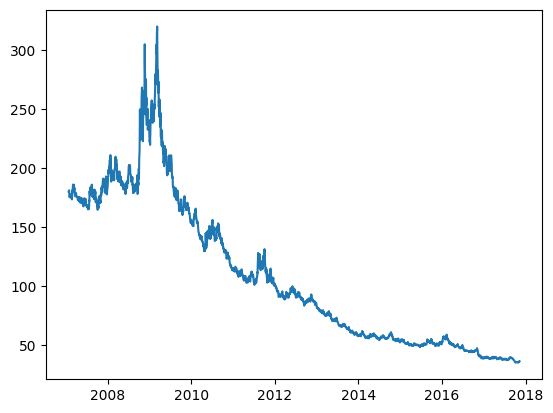

In [149]:
df['Date'] = pd.to_datetime(df['Date'])
import matplotlib.pyplot as plt
plt.plot(df['Date'], df['Close'])

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)
        self.act=nn.Sigmoid()
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x.float(), (h0, c0))
        out = self.act(self.fc(out[:, -1, :]))
        return out

model = LSTM(4, 128, 3)
model.to(device)
model

LSTM(
  (lstm): LSTM(4, 128, num_layers=3, batch_first=True)
  (act): Sigmoid()
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class AttentionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_heads):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads

        # Linear transformations for query, key, and value
        self.query_linear = nn.Linear(input_size, hidden_size)
        self.key_linear = nn.Linear(input_size, hidden_size)
        self.value_linear = nn.Linear(input_size, hidden_size)

        self.fc = nn.Linear(hidden_size, 1)
        self.act=nn.Sigmoid()


    def scaled_dot_product_attention(self, query, key, value):
        """
        Calculates scaled dot-product attention.

        Args:
            query (torch.Tensor): Query tensor (batch_size, seq_len, hidden_size).
            key (torch.Tensor): Key tensor (batch_size, seq_len, hidden_size).
            value (torch.Tensor): Value tensor (batch_size, seq_len, hidden_size).

        Returns:
            torch.Tensor: Attention output (batch_size, hidden_size).
        """
        d_k = query.size(-1)  # hidden_size

        # Calculate attention scores (batch_size, seq_len, seq_len)
        scores = torch.matmul(query, key.transpose(-2, -1)) / np.sqrt(d_k)

        # Apply softmax to get attention weights (batch_size, seq_len, seq_len)
        attention_weights = F.softmax(scores, dim=-1)

        # Apply attention weights to values (batch_size, seq_len, hidden_size)
        attention_output = torch.matmul(attention_weights, value)
        # Average the output over the sequence length (batch_size, hidden_size)
        attention_output = torch.mean(attention_output, dim=1)
        return attention_output

    def forward(self, x):
        """
        Forward pass of the attention model.

        Args:
            x (torch.Tensor): Input tensor (batch_size, seq_len, input_size).

        Returns:
            torch.Tensor: Output tensor (batch_size, 1).
        """
        batch_size = x.size(0)
        seq_len = x.size(1)

        # Linear transformations
        query = self.query_linear(x)  # (batch_size, seq_len, hidden_size)
        key = self.key_linear(x)  # (batch_size, seq_len, hidden_size)
        value = self.value_linear(x)  # (batch_size, seq_len, hidden_size)

        # Calculate attention output
        attention_output = self.scaled_dot_product_attention(query, key, value)  # (batch_size, hidden_size)

        # Fully connected layer and sigmoid activation
        out = (self.fc(attention_output))  # (batch_size, 1)
        return out

# Example usage:
input_size = 4  # Number of features
hidden_size = 128  # Hidden size for attention
num_heads = 8 # Number of attention heads
model = AttentionModel(input_size, hidden_size, num_heads)
model.to(device)
print(model)

AttentionModel(
  (query_linear): Linear(in_features=4, out_features=128, bias=True)
  (key_linear): Linear(in_features=4, out_features=128, bias=True)
  (value_linear): Linear(in_features=4, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (act): Sigmoid()
)


In [152]:

def train_one_epoch(epoch,loss_function,optimizer):
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch.float())
        loss = loss_function(output.float(), y_batch.float())
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.8f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()
    
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch.float())
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.8f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [153]:
learning_rate = 0.0001
num_epochs = 100
#optimizer=torch.optim.SGD(lr=0.00001,weight_decay=0.000001)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch(epoch)
    validate_one_epoch()
learning_rate = 0.0000001
num_epochs = 200
#optimizer=torch.optim.SGD(lr=0.00001,weight_decay=0.000001)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch(epoch)
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.14601263

Val Loss: 0.02364557
***************************************************

Epoch: 2
Batch 100, Loss: 0.00727091

Val Loss: 0.00134167
***************************************************

Epoch: 3
Batch 100, Loss: 0.00112216

Val Loss: 0.00006248
***************************************************

Epoch: 4
Batch 100, Loss: 0.00070110

Val Loss: 0.00001744
***************************************************

Epoch: 5
Batch 100, Loss: 0.00062632

Val Loss: 0.00001653
***************************************************

Epoch: 6
Batch 100, Loss: 0.00062430

Val Loss: 0.00001900
***************************************************

Epoch: 7
Batch 100, Loss: 0.00068475

Val Loss: 0.00001971
***************************************************

Epoch: 8
Batch 100, Loss: 0.00064978

Val Loss: 0.00001591
***************************************************

Epoch: 9
Batch 100, Loss: 0.00059004

Val Loss: 0.00001586
*********************************************

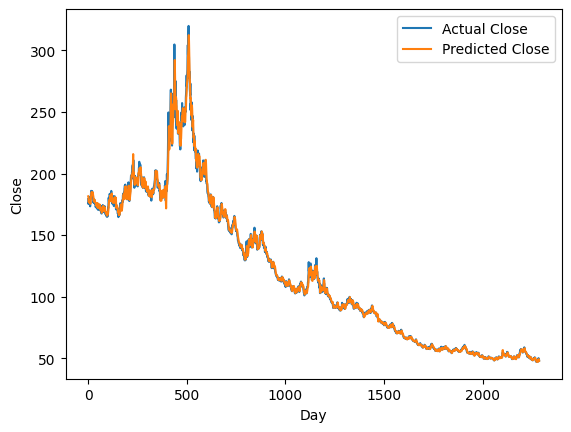

In [154]:
with torch.no_grad():
    predicted = model(torch.tensor(X_train).float().to(device)).to('cpu').numpy()
x_original, y_original = dataset_creator.inverse_transform(X_train, y_train)
x_original, y_pred = dataset_creator.inverse_transform(X_train, predicted)

plt.plot(y_original, label='Actual Close')
plt.plot(y_pred, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


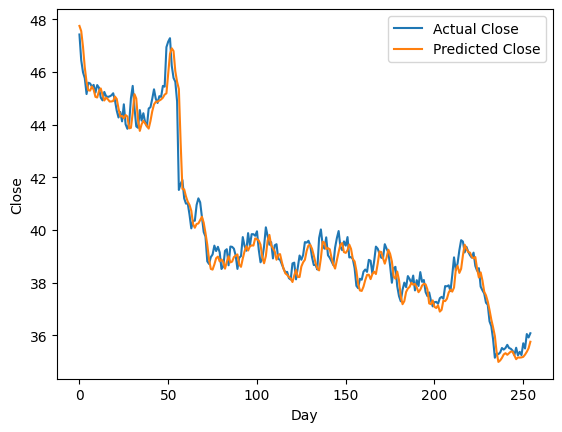

In [155]:
with torch.no_grad():
    predicted = model(torch.tensor(X_test).float().to(device)).to('cpu').numpy()
x_original, y_original = dataset_creator.inverse_transform(X_test, y_test)
x_original, y_pred = dataset_creator.inverse_transform(X_test, predicted)

plt.plot(y_original, label='Actual Close')
plt.plot(y_pred, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
